<H1>Battle of Neighborhoods</H1>
<H2>Where to open my Tea Room?</H2>
<p>
<H3>Table of Contents</H3>
<li><a href="#load">Load Libraries
<li><a href="#init">Initialize API connection
<li><a href="#caps">Scrape world capitals coordinates
<li><a href="#venu">Query Foursquare for Coffee & Tea venues
<li><a href="#pcct">Coffee-Tea per Capita Consumption
<li><a href="#mapv">Map visualisation
<li><a href="#unsu">Unsupervised Learning
<li><a href="#syno">Synopsis



---
<H3><span id="load">Load libraries

In [1]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00   1.07 MB/s
geopy-1.17.0-p 100% |################################| Time: 0:00:00   1.50 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   3.10 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  25.63 MB/s
vincent-0.4.4- 100% |###################

In [2]:
import numpy as np
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import branca

print('Libraries imported.')

Libraries imported.


<H3><span id="init">Initialize API connection & make test query

In [3]:
CLIENT_ID = '3DO3N550RX4XMAL3WG2TOTCILJBUYE2DDOMIKA410AP4KRKC' # your Foursquare ID
CLIENT_SECRET = 'YNDFTPZXCG3NGCT5MUGRCEMPKBPZMPZPY2LYWOSQ4YLOEBOB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [4]:
address = 'Athens, Greece'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = 37.976386  #location.latitude
longitude = 23.726139 #location.longitude
print('The geograpical coordinate of Athens, Greece are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Athens, Greece are 37.976386, 23.726139.


In [60]:
LIMIT = 100
radius = 50000
section = 'sights'
query = 'coffee'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT)
url_id = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT, section)
url_cat = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
url_mu = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT, query)

results = requests.get(url_mu).json()

---
<H3><span id="caps">Scrape world capitals coordinates

In [6]:
# Load website source code and retain only code containing table data
website_url = requests.get('https://www.jasom.net/list-of-capital-cities-with-latitude-and-longitude').text
website_table = website_url.split('<pre>')
website_table = website_table[1].split('</pre>')
# Split into rows
website_table = website_table[0].split("\n")

# Split rows into columns
splitStr = "</td>\\n<td>"
website_list = []
for row in website_table:
    row_df = row.split(",")
    website_list.append(row_df)

# Place cells into dataframe, clear strings from HTML tags, drop NaN cells
website_df = pd.DataFrame(website_list, columns=['Country', 'Capital', 'Latitude', 'Longitude'])
website_df.drop([0,1], inplace=True)
website_df.reset_index(drop=True, inplace=True)
website_df["Capital"] = website_df["Country"] + ", " + website_df["Capital"]
website_df.head()

,Country,Capital,Latitude,Longitude
0,Abkhazia,"Abkhazia, Sukhumi",43.001525,41.023415
1,Afghanistan,"Afghanistan, Kabul",34.575503,69.240073
2,Aland Islands,"Aland Islands, Mariehamn",60.1,19.933333
3,Albania,"Albania, Tirana",41.327546,19.818698
4,Algeria,"Algeria, Algiers",36.752887,3.042048


<H3><span id="venu">Query Foursquare for Coffee & Tea venues

In [7]:
# Method to query Foursquare for all venues within 5000m-radius from specified location
def getSites(names, latitudes, longitudes, query):
    
    venues_list=[]
    LIMIT = 100
    radius = 5000

    for name, lat, lng in zip(names, latitudes, longitudes):
        try:
            #print(name)
            urlmu = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT, query)
            results = requests.get(urlmu).json()["response"]['groups'][0]['items']
            venues_list.append([(name,lat,lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            break
# Return each venue as row
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital','CptLat','CptLon','Shop','ShpLat','ShpLon','ShpCat']
    
    return(nearby_venues)

In [8]:
# Query Foursquare for venues in all world capitals whose description/name/category has the string 'coffee' in it
# Return results as dataframe
capital_cof = getSites(names=website_df['Country'],#.head(2),
                                latitudes=website_df['Latitude'],
                                longitudes=website_df['Longitude'],
                                query='coffee')
print("Finished")

Finished


In [9]:
# Query Foursquare for venues in all world capitals whose description/name/category has the string 'tea' in it
# Return results as dataframe
capital_tea = getSites(names=website_df['Country'],#.head(2),
                                latitudes=website_df['Latitude'],
                                longitudes=website_df['Longitude'],
                                query='tea')
print("Finished")

Finished


In [10]:
# Count all venues that serve coffee in each city
capital_sum_cof = capital_cof.groupby(['Capital']).count()
capital_sum_cof.drop(columns=['CptLat','CptLon','Shop','ShpLat','ShpLon'], inplace=True)
capital_sum_cof.head()

,ShpCat
Capital,
Abkhazia,10
Afghanistan,3
Aland Islands,6
Albania,50
Algeria,16


In [11]:
# Count all venues that serve tea in each city
capital_sum_tea = capital_tea.groupby(['Capital']).count()
capital_sum_tea.drop(columns=['CptLat','CptLon','Shop','ShpLat','ShpLon'], inplace=True)
capital_sum_tea.head()

,ShpCat
Capital,
Abkhazia,3
Aland Islands,1
Albania,12
Algeria,5
Andorra,2


In [12]:
# Calculate the ratio between venues serving coffee and those serving tea for each city
capital_sum = capital_sum_cof.join(capital_sum_tea, how='inner', lsuffix='_coffee', rsuffix='_tea')
capital_sum['RatioCT'] = capital_sum['ShpCat_coffee']/capital_sum['ShpCat_tea']
capital_sum.sort_values(by=['RatioCT']).head()

,ShpCat_coffee,ShpCat_tea,RatioCT
Capital,,,
Maldives,42,77,0.545455
Iran,100,100,1.000000
Russia,100,100,1.000000
Chad,1,1,1.000000
Saint Pierre and Miquelon,1,1,1.000000


<H3>Restrict results to Coffee Shops and Tea Rooms

In [13]:
# Retain only results concerning specialty coffee shops
capital_flt_cof = capital_cof.loc[capital_cof['ShpCat'].isin(['Cafeteria', 'Café', 'Coffee Shop'])].groupby(['Capital']).count()
capital_flt_cof.drop(columns=['CptLat','CptLon','Shop','ShpLat','ShpLon'], inplace=True)
capital_flt_cof.head()

,ShpCat
Capital,
Abkhazia,8
Afghanistan,3
Aland Islands,5
Albania,44
Algeria,13


In [14]:
# Retain only results concerning specialty tea shops
capital_flt_tea = capital_tea.loc[capital_tea['ShpCat'] == 'Tea Room'].groupby(['Capital']).count()
capital_flt_tea.drop(columns=['CptLat','CptLon','Shop','ShpLat','ShpLon'], inplace=True)
capital_flt_tea.head()

,ShpCat
Capital,
Abkhazia,1
Albania,1
Algeria,4
Andorra,2
Argentina,17


In [15]:
# Calculate the ratio between coffee shops and tea rooms for each city
capital_flt = capital_flt_cof.join(capital_flt_tea, how='inner', lsuffix='_coffee', rsuffix='_tea')
capital_flt['RatioCT'] = capital_flt['ShpCat_coffee']/capital_flt['ShpCat_tea']
capital_flt.sort_values(by=['RatioCT'],inplace=True)
capital_flt.head()

,ShpCat_coffee,ShpCat_tea,RatioCT
Capital,,,
Martinique,1,4,0.250000
French Polynesia,1,3,0.333333
Côte d&#39;Ivoire,1,1,1.000000
Equatorial Guinea,1,1,1.000000
New Caledonia,3,3,1.000000


<H3><span id="pcct">Coffee-Tea per Capita Consumption

<H4>Scrape coffee consumption from blogpost for top-49 countries (Data from euromonitor.com)

In [50]:
# Load website source code and retain only code containing table data
website_url = requests.get('https://www.caffeineinformer.com/caffeine-what-the-world-drinks').text
website_table = website_url.split('<ol>')
website_table = website_table[1].split('</ol>')

# Split into rows
website_table = website_table[0].split("<li>")

# Split rows into columns
#splitStr = "</td>\\n<td>"
website_list = []
for row in website_table:
    row_df = row.split(":")
    try:
        row_df[0] = row_df[0].replace('<strong>', '').replace('</strong>', '')
        row_df[1] = row_df[1].split(" ")[1].replace('\xa0', '')
        #print(row_df)
    except:
        continue
    website_list.append(row_df)

    
# Place cells into dataframe, clear strings from HTML tags, drop NaN cells
cof_con_df = pd.DataFrame(website_list, columns=['Capital', 'Consumption'])
cof_con_df.head()

,Capital,Consumption
0,Finland,9.6
1,Norway,7.2
2,Slovenia,6.1
3,Austria,5.5
4,Serbia,5.4


<H4>Scrape tea consumption from Wikipedia for leading countries (data from Statista)

In [51]:
# Load website source code and retain only code containing table data
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_tea_consumption_per_capita').text
website_table = website_url.split('<tbody>')
website_table = website_table[1].split('</tbody>')

# Split into rows
website_table = website_table[0].split("<tr>")

# Split rows into columns
#splitStr = "</td>\\n<td>"
website_list = []
for row in website_table:
    row_df = row.split("<td>")
    try:
        row_df[1] = row_df[1].split('">')[2].split("</a>")[0]
        row_df[2] = row_df[2].split("(")[1].split("&")[0]
    except:
        continue
    website_list.append(row_df)

    
# Place cells into dataframe, clear strings from HTML tags, drop NaN cells
tea_con_df = pd.DataFrame(website_list, columns=['Num', 'Capital', 'Consumption'])
tea_con_df.drop(['Num'], axis=1, inplace=True)
tea_con_df.head()

,Capital,Consumption
0,Turkey,3.16
1,Ireland,2.19
2,United Kingdom,1.94
3,Russia,1.38
4,Morocco,1.22


In [52]:
# Calculate the ratio between coffee and tea consumption in each country
consumption_ct = cof_con_df.set_index('Capital').join(tea_con_df.set_index('Capital'), how='inner', lsuffix='_coffee', rsuffix='_tea')
consumption_ct[['Consumption_coffee','Consumption_tea']] = consumption_ct[['Consumption_coffee','Consumption_tea']].apply(pd.to_numeric)
consumption_ct['RatioCT'] = consumption_ct['Consumption_coffee']/consumption_ct['Consumption_tea']
consumption_ct.sort_values(by=['RatioCT'], inplace=True)
consumption_ct.head()

,Consumption_coffee,Consumption_tea,RatioCT
Capital,,,
New Zealand,1.3,1.19,1.092437
Japan,1.5,0.97,1.546392
Hong Kong,1.3,0.65,2.000000
Malaysia,1.3,0.48,2.708333
Poland,3.1,1.00,3.100000


In [53]:
# Compare Shop vs Consumption Ratios for all countries with available data for both
comparison_ct = capital_flt.join(consumption_ct, how='inner', lsuffix='_shops', rsuffix='_consumption')
comparison_ct.drop(['ShpCat_coffee','ShpCat_tea','Consumption_coffee','Consumption_tea'], axis=1, inplace=True)
comparison_ct['RatioCT_RatioSC'] = comparison_ct['RatioCT_shops']/comparison_ct['RatioCT_consumption']
comparison_ct.sort_values(by=['RatioCT_RatioSC'], ascending=False, inplace=True)
comparison_ct.head()

,RatioCT_shops,RatioCT_consumption,RatioCT_RatioSC
Capital,,,
New Zealand,10.00,1.092437,9.153846
Israel,81.00,9.000000,9.000000
Australia,22.50,3.466667,6.490385
Poland,13.00,3.100000,4.193548
Malaysia,8.75,2.708333,3.230769


---
<H3><span id="mapv">Map visualisation

In [54]:
# Join previous results with initial dataframe containing location data for each capital
consumption_coo = comparison_ct.join(website_df.set_index('Country'), how='inner')
consumption_coo

,RatioCT_shops,RatioCT_consumption,RatioCT_RatioSC,Capital,Latitude,Longitude
New Zealand,10.000000,1.092437,9.153846,"New Zealand, Wellington",-41.28646,174.776236
Israel,81.000000,9.000000,9.000000,"Israel, Tel Aviv",32.0853,34.781768
Australia,22.500000,3.466667,6.490385,"Australia, Canberra",-35.282,149.128684
Poland,13.000000,3.100000,4.193548,"Poland, Warsaw",52.229676,21.012229
Malaysia,8.750000,2.708333,3.230769,"Malaysia, Kuala Lumpur",3.139003,101.686855
Japan,4.142857,1.546392,2.679048,"Japan, Tokyo",35.709026,139.731992
Hong Kong,4.500000,2.000000,2.250000,"Hong Kong, Hong Kong",22.396428,114.109497
Switzerland,16.000000,8.863636,1.805128,"Switzerland, Bern",46.947974,7.447447
Czech Republic,8.100000,5.476190,1.479130,"Czech Republic, Prague",50.075538,14.4378
Germany,10.000000,7.536232,1.326923,"Germany, Berlin",52.520007,13.404954


In [55]:
# Create world map using latitude and longitude values for each capital
consumption_map = folium.Map(location=[0, 0], zoom_start=2)


colorscale_shp = branca.colormap.linear.YlOrRd_09.scale(0, 10)
colorscale_con = branca.colormap.linear.PuRd_09.scale(0, 10)

# Add markers to map
for lat, lng, ratShp, ratCon, label in zip(pd.to_numeric(consumption_coo['Latitude']),
                                           pd.to_numeric(consumption_coo['Longitude']),
                                           pd.to_numeric(consumption_coo['RatioCT_shops']),
                                           pd.to_numeric(consumption_coo['RatioCT_consumption']),
                                           consumption_coo['Capital']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=50/ratCon, # Radius represents increasing tea consumption in specific country
        popup=label,
        color=colorscale_shp(ratShp), # Red color scale represents decreasing Tea Room locations in query area
        fill=True,
        fill_color=colorscale_shp(ratShp),
        fill_opacity=0.5,
        parse_html=False).add_to(consumption_map)  
    
consumption_map

<a href="https://ibb.co/fz80OA"><img src="https://preview.ibb.co/bWo0OA/map.png" alt="map" border="0"></a>

---
<H3><span id="unsu">Unsupervised Learning

<H4>Hierarchical Clustering

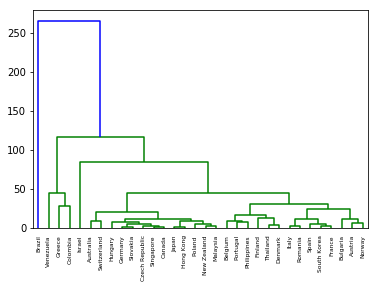

In [56]:
# Importing Modules
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

#seeds_df = comparison_ct
varieties = list(comparison_ct['RatioCT_RatioSC'])
samples = comparison_ct[['RatioCT_shops','RatioCT_consumption']].values
lbl = comparison_ct.index.tolist()

mergings = linkage(samples, method='complete')
dendrogram(mergings,
           labels=lbl,
           leaf_rotation=90,
           leaf_font_size=6,
           )
plt.show()

<H4>k-Means Clustering

In [57]:
# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(samples.data)
clusters = model.predict(samples.data)

print(clusters)

[0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 2 0 0 1 0]


---
<H3><span id="syno">Synopsis